In [406]:
import simpy
import random
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
%matplotlib inline

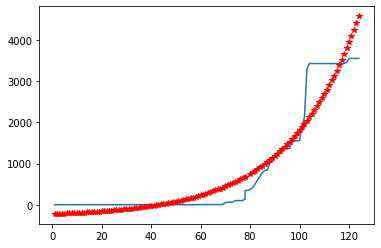

In [475]:
df = pd.read_csv('Covid-EC.csv', sep=',')

x = list(df.iloc[:, 0]) #dias
y = list(df.iloc[:, 6]) #recuperados

def reg_exponencial(x, c0, c1, c2, c3):
    return c0 * np.exp(-c1 * x) + c2 + c3

g = [100, 0.01, 200, 0.01]
pre = np.empty(len(y))
for i in range(len(y)):
    pre[i] = reg_exponencial(x[i], g[0], g[1], g[2], g[3])
    
popt, pcov = curve_fit(reg_exponencial, x, y, g)
for i in range(len(y)):
    pre[i] = reg_exponencial(x[i], popt[0], popt[1], popt[2], popt[3])
pp.plot(x, y)
pp.plot(x, pre, 'r*')

Prediccion 7 dias  5726 recuperados


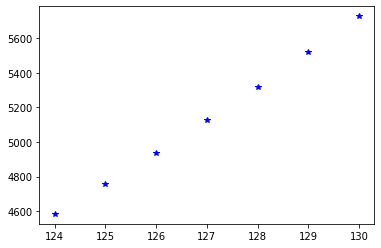

In [476]:
predi7 = np.array([i for i in range(len(x), len(x)+7)], dtype = float)
pp.plot(predi7, reg_exponencial(predi7, *popt), 'b*')
print('Prediccion 7 dias ', (int(reg_exponencial(predi7, *popt)[-1])), 'recuperados')

Prediccion 30 dias  13675 recuperados


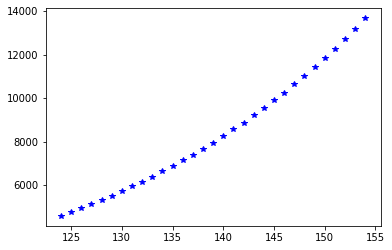

In [477]:
predi30 = np.array([i for i in range(len(x), len(x)+31)], dtype = float)
pp.plot(predi30, reg_exponencial(predi30, *popt), 'b*')
print('Prediccion 30 dias ', (int(reg_exponencial(predi30, *popt)[-1])), 'recuperados')

Recuperados para el dia 7:  6848


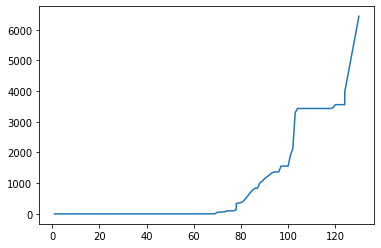

In [478]:
mediana = np.median(yt)
for i in range(x[-1], x[-1]+7):
    x.append(i)
    y.append(int(y[-1] + mediana))
pp.plot(x, y)
print('Recuperados para el dia 7: ',int(y[-1] + mediana))

Recuperados para el dia 30:  19178
Media 1474.7639751552795


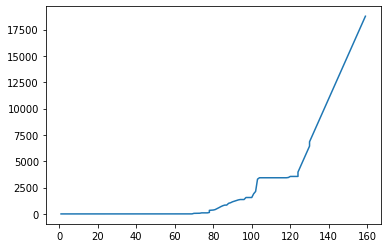

In [479]:
media = np.mean(yt)
mediana = np.median(yt)
for i in range(x[-1], x[-1]+30):
    x.append(i)
    y.append(int(y[-1] + mediana))
pp.plot(x, y)
print('Recuperados para el dia 30: ',int(y[-1] + mediana))
print('Media', media)

3991.803688442025


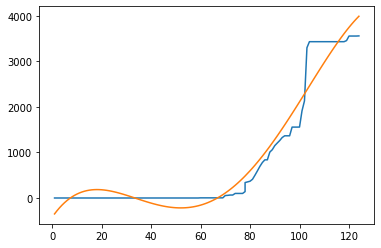

In [438]:
df = pd.read_csv('Covid-EC.csv', sep=',')

x = np.array(list(df.iloc[:, 0])) #dias
y = np.array(list(df.iloc[:, 6])) #recuperados

model = LinearRegression()
poly = PolynomialFeatures(degree=4, include_bias=True)
x_poli = poly.fit_transform(x.reshape(-1, 1))
model.fit(x_poli, y)
y_pred = model.predict(x_poli)
pp.plot(x, y)
pp.plot(x, y_pred)
print(y_pred[-1])

In [526]:
personas_teletrabajo = []
personas_presencial = []
personas_despedidas = []
mes = []
tipo_trabajo = []

In [516]:
class Persona:
    nombre = ''
    estado_trabajo = True
    tipo_trabajo = ''
    forma_trabajo = ''
    test = False
    
    def __init__(self, nombre, estado_trabajo, tipo_trabajo, forma_trabajo, test):
        self.nombre = nombre
        self.estado_trabajo = estado_trabajo
        self.tipo_trabajo = tipo_trabajo
        self.forma_trabajo = forma_trabajo
        self.test = test

In [525]:
class Simulacion:
    def __init__(self, env, estacion):
        self.env = env
        self.estacion = simpy.Resource(env, estacion)
    
    def dayToMonth(self, dia):
        if dia >= 0 and dia <= 30:
            return 'enero'
        if dia > 30 and dia <= 60:
            return 'febrero'
        if dia > 60 and dia <= 90:
            return 'marzo'
        if dia > 90 and dia <= 120:
            return 'abril'
        if dia > 120 and dia <= 150:
            return 'mayo'
        if dia > 150 and dia <= 180:
            return 'junio'
        if dia > 180 and dia <= 210:
            return 'julio'
        if dia > 210 and dia <= 240:
            return 'agosto'
        if dia > 240 and dia <= 270:
            return 'septiembre'
        if dia > 270 and dia <= 300:
            return 'octubre'
        if dia > 300 and dia <= 330:
            return 'noviembre'
        if dia > 330:
            return 'diciembre'
    
    def notificacion_depidos(self, persona):
        posibilidad = random.randint(1, 7)
        if posibilidad > 6:
            persona.estado_trabajo = False
            print('Se ha notificado que a la persona ', persona.nombre, ' ha sido DESPEDIDA de su cargo')
            personas_despedidas.append(persona)
        else:
            print('Se ha notificado que a la persona ', persona.nombre, ' aun CONSERVA su cargo')
        yield self.env.timeout(1)
    
    def descanso_previo(self, persona):
        tiempo = random.randint(1, 7)
        yield self.env.timeout(tiempo)
        print('La persona', persona.nombre, ' descanso: ', tiempo, ' dias')
    def teletrabajo(self, persona):
        self.realizar_test(persona)
        if  persona.test == False:
            tiempo = random.randint(4, 15)
            yield self.env.timeout(tiempo)
            print('La persona', persona.nombre, ' empezo con el teletrabajo al dia: ',tiempo)
        else:
            tiempo = random.randint(4, 15)
            yield self.env.timeout(tiempo)
            print('La persona', persona.nombre, ' no paso el test de COVID CONTINUA con teletrabajo ',tiempo, 'dias mas')
    
    def realizar_test(self, persona):
        posibilidad = random.randint(0, 10) + 1
        if posibilidad < 8:
            persona.test = True
            personas_presencial.append(persona)
            persona.forma_trabajo = 'Presencial'
            print('La persona', persona.nombre, ' Retoma su trabajo normal en  el area de ', persona.tipo_trabajo, 'TIEMPO ANUAL')
            month = self.dayToMonth(self.env.now)
            area = persona.tipo_trabajo
            mes.append(month)
            tipo_trabajo.append(area)
        else:
            persona.test = False
            personas_teletrabajo.append(persona)
        


In [497]:
def simular(env, persona, simulacion):
    with simulacion.estacion.request() as estacion:
        yield estacion
        print('Notificacion estado de trabajo')
        yield env.process(simulacion.notificacion_depidos(persona))
        
    if persona.estado_trabajo:
        yield env.process(simulacion.descanso_previo(persona))
        yield env.process(simulacion.teletrabajo(persona))

In [527]:
def ejecutar_simulacion(env, estacion):
    simulacion = Simulacion(env, estacion)
    for persona in personas:
        yield env.timeout(1)
        env.process(simular(env, persona, simulacion))
env = simpy.Environment()
env.process(ejecutar_simulacion(env, 5000))
env.run(until = 365)

Notificacion estado de trabajo
Se ha notificado que a la persona  persona(0)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(1)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(2)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(3)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(4)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(5)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(6)  ha sido DESPEDIDA de su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(7)  ha sido DESPEDIDA de su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(8)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(9)  aun CO

Notificacion estado de trabajo
Se ha notificado que a la persona  persona(236)  aun CONSERVA su cargo
La persona persona(225)  no paso el test de COVID CONTINUA con teletrabajo  4 dias mas
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(237)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(238)  ha sido DESPEDIDA de su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(239)  aun CONSERVA su cargo
La persona persona(233)  descanso:  6  dias
La persona persona(234)  descanso:  5  dias
La persona persona(233)  Retoma su trabajo normal en  el area de  retail TIEMPO ANUAL
La persona persona(234)  Retoma su trabajo normal en  el area de  hoteles TIEMPO ANUAL
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(240)  aun CONSERVA su cargo
La persona persona(226)  no paso el test de COVID CONTINUA con teletrabajo  13 dias mas
Notificacion estado de trabajo
Se ha notificad

La persona persona(351)  no paso el test de COVID CONTINUA con teletrabajo  6 dias mas
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(362)  aun CONSERVA su cargo
Notificacion estado de trabajo
Se ha notificado que a la persona  persona(363)  aun CONSERVA su cargo


In [463]:
total_personas = 1474 #obtenida de la media
personas = []
#generar personas
for i in range(0, total_personas):
    persona = Persona('persona(%d)'%i, True, actividad(), 'teletrabajo', False)
    personas.append(persona)
    persona = None

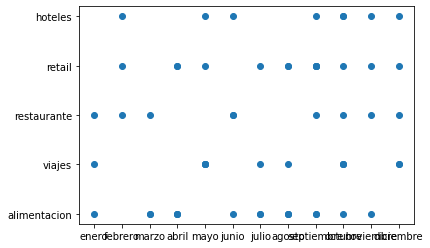

In [572]:
pp.scatter([m for m in mes], [tp for tp in tipo_trabajo], marker='o')
pp.show()

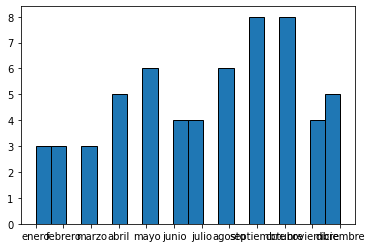

In [542]:
pp.hist([ m for m in mes], bins=20, edgecolor = 'black',linewidth=1)
pp.show()

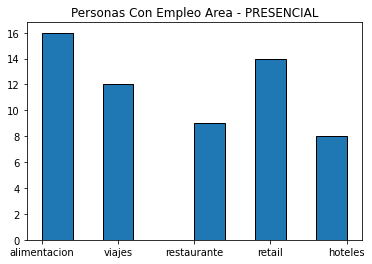

In [544]:
pp.title('Personas Con Empleo Area - PRESENCIAL')
pp.hist([persona.tipo_trabajo for persona in personas_presencial], bins=10, edgecolor = 'black',linewidth=1)
pp.show()

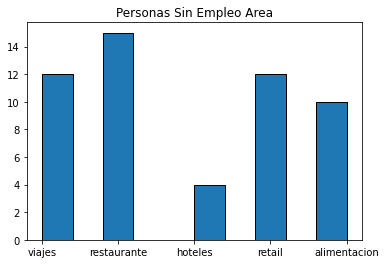

In [545]:
pp.title('Personas Sin Empleo Area')
pp.hist([persona.tipo_trabajo for persona in personas_despedidas], bins=10, edgecolor = 'black',linewidth=1)
pp.show()

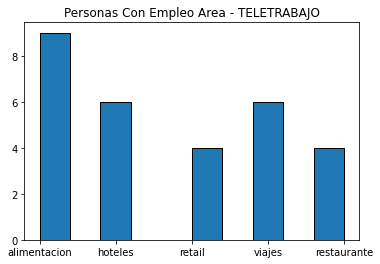

In [546]:
pp.title('Personas Con Empleo Area - TELETRABAJO')
pp.hist([persona.tipo_trabajo for persona in personas_teletrabajo], bins=10, edgecolor = 'black',linewidth=1)
pp.show()

In [173]:
def actividad():
    a = random.randint(0, 4)
    print(a)
    if a == 0:
        return 'alimentacion'
    if a == 1:
        return 'retail'
    if a == 2:
        return 'restaurante'
    if a == 3:
        return 'viajes'
    if a == 4:
        return 'hoteles'